In [601]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import joblib

In [578]:
# Step 1: Data Preparation and Exploration
df = pd.read_csv('credit_customers.csv')

In [579]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [580]:
df.shape

(1000, 21)

In [581]:
df.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

In [582]:
df.isnull().sum().sum()

0

In [583]:
df.loc[df.duplicated()]

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class


In [584]:
duplicated_rows = df.loc[df.duplicated()]

In [585]:
df.drop_duplicates(keep='first', inplace=True)

In [586]:
df.loc[df.duplicated()]

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class


In [587]:
empty_rows=df.isnull().all(axis=1)

In [588]:
df.isnull().sum().sum()

0

In [589]:
df.to_csv('clean_credit.csv', index=False)

In [590]:
clean_data = pd.read_csv('clean_credit.csv')

In [591]:
print(clean_data.columns)


Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')


In [592]:

# Separate the features and target variable
X = clean_data.drop('class', axis=1)
y = clean_data['class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [593]:
# Define the transformers for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age',
                                        'existing_credits', 'num_dependents']),
        ('cat', categorical_transformer, ['checking_status', 'credit_history', 'purpose', 'savings_status',
                                           'employment', 'personal_status', 'other_parties', 'property_magnitude',
                                           'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker'])
    ])

# Preprocess the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed,
                                  columns=['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age',
                                           'existing_credits', 'num_dependents'] +
                                          preprocessor.named_transformers_['cat'].get_feature_names_out(
                                              ['checking_status', 'credit_history', 'purpose', 'savings_status',
                                               'employment', 'personal_status', 'other_parties', 'property_magnitude',
                                               'other_payment_plans', 'housing', 'job', 'own_telephone',
                                               'foreign_worker']).tolist())

# Preprocess the test data
X_test_processed = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed,
                                 columns=['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age',
                                          'existing_credits', 'num_dependents'] +
                                         preprocessor.named_transformers_['cat'].get_feature_names_out(
                                             ['checking_status', 'credit_history', 'purpose', 'savings_status',
                                              'employment', 'personal_status', 'other_parties', 'property_magnitude',
                                              'other_payment_plans', 'housing', 'job', 'own_telephone',
                                              'foreign_worker']).tolist())

# Handle missing values in the processed data
numerical_imputer = SimpleImputer(strategy='mean')
X_train_processed[['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age',
                   'existing_credits', 'num_dependents']] = numerical_imputer.fit_transform(
    X_train_processed[['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age',
                        'existing_credits', 'num_dependents']])
X_test_processed[['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age',
                  'existing_credits', 'num_dependents']] = numerical_imputer.transform(
    X_test_processed[['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age',
                       'existing_credits', 'num_dependents']])


In [594]:





# Train the model
xgb_model = GradientBoostingClassifier()
xgb_model.fit(X_train_processed, y_train)



GradientBoostingClassifier()

In [602]:
# Save the model as a .pkl file
joblib.dump(xgb_model, "gradient_boosting_model.pkl")

['gradient_boosting_model.pkl']

In [595]:
# Evaluate the model
accuracy = xgb_model.score(X_test_processed, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8


In [596]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test_processed)

In [597]:

# Calculate classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

         bad       0.72      0.53      0.61        59
        good       0.82      0.91      0.87       141

    accuracy                           0.80       200
   macro avg       0.77      0.72      0.74       200
weighted avg       0.79      0.80      0.79       200



In [598]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, pos_label='good')
recall = recall_score(y_test, y_pred, pos_label='good')
f1 = f1_score(y_test, y_pred, pos_label='good')


In [599]:


print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.821656050955414
Recall: 0.9148936170212766
F1 Score: 0.865771812080537


AUC-ROC Score: 0.8204111071042192


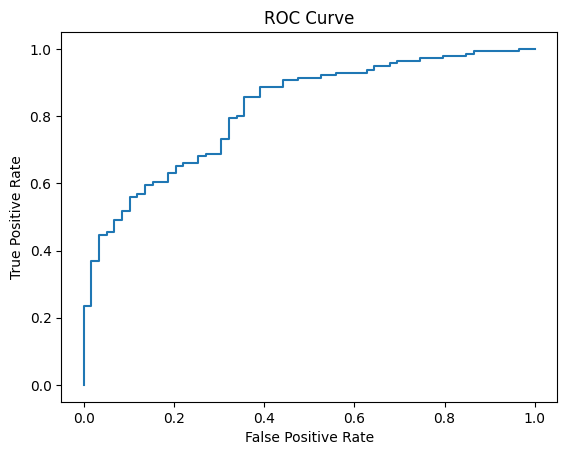

In [600]:
# Calculate AUC-ROC
y_prob = xgb_model.predict_proba(X_test_processed)[:, 1]
auc_roc = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc_roc)

# Convert string labels to binary format
y_test_bin = np.where(y_test == 'good', 1, 0)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob)

import matplotlib.pyplot as plt

# ... Your code ...

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

